## Further Reaching Analysis: Linear Modeling

For our further analysis, we want to check different predictors and understand how each of them influences the outcome variable. We discussed whether to use RewP or voltage (mean/max) as the outcome variable and decided to use RewP. We theorize that analyzing voltage alone does not extract much information from the data, even if we epoch the data and select only the relevant time interval as specified in the paper (240ms to 340ms). This is due to the simple fact that raw voltage values alone do not carry much meaning. 

Using voltages as the dependent variable for our linear model first came into discussion because RewP is not trial-based. To recap, RewP is "the difference-wave method by subtracting the mean loss ERP from the corresponding mean gain ERP for each task and cue" (quoted from the paper). Since we compute the mean for each task-cue-outcome combination, we would be averaging over all trials in each combination. Thus, we are no longer able to use trial-based predictors such as **previous outcome**. To still be able to use the aforementioned variable as a predictor, we slightly change how RewP is calculated (for linear modeling only). Instead of subtracting the mean task-cue-loss combination from the mean task-cue-win, we add another constraint in the previous outcome. From now on, we compute RewP by subtracting the mean task-cue-prev_outcome loss from the mean win in the same combination. Thus, it is now possible to check the influence of the previous outcome on the RewP. Furthermore, this method provides the much-needed more data points for analysis, as only 12 out of 36 participants are included in the dataset.

Finally, the RewP is calculated by averaging the maximum voltage values across all epochs in the selected channel (in our case "FCz") and considering only the relevant time interval (here 240ms to 340ms) for each task-cue-prev_outcome combination.


In [1]:
# HYPTERPARAMETERS
VOLTAGE_TO_ANALYZE = "RewP"
SELECTED_CHANNEL="FCz"
OUTPUT_DIR=None  # None means don't save as csv
SUBJECTS_TO_INCLUDE=None # None means all
RAW_DS_PATH="Dataset/ds004147"

FILT_DS_PATH_WITH_PREV_OUT="Dataset/ds004147-filtered_prev_out"
USE_BEH_WITH_PREV_OUT = True  # use beh if you want to include prev_outcome

CLEANED_FILT_DS_PATH_WO_PREV_OUT="Dataset/ds004147-filtered"
USE_BEH_WO_PREV_OUT = False  # use beh if you want to include prev_outcome

In [2]:
# import all helper functions
from utils import *

## Important Note

For linear modeling, we only need the sub-X_task-casinos_proc-clean_epo.fif to get the voltage values in each epoch and the sub-X_task-casinos_events.tsv to get the sample ids of each epoch, which can then be mapped to the sub-X_task-casinos_beh.tsv to get the corresponding previous result. Unfortunately, during the manual ICA step, the sample ids of the epochs do not match the sub-X_task-casinos_beh.tsv. Therefore, we are no longer able to retrieve the corresponding previous result for each epoch. 

To still be able to check the influence of the previous result on the RewP value, we decided to use the mne_bids_pipeline to automatically perform the ICA step that uses one epoch for both ICA training and applying it, namely the epoch around the feedback events in the experiment. We then realized that to correctly replicate the process of the original paper, we needed to train the ICA on epochs around the cue presentation and then apply it on epochs around the subjects' feedback.

In the next steps, both the data where the previous outcome can be mapped and the data with the correct preprocessing steps will be analyzed simultaneously.

### Sanity Check: Are voltage values correctly retrieved?

To verify that our implementation correctly retrieves the epoch values and then correctly averages them across the specified task-cue pair, we plot the averaged epoch values for the high task and high cue on loss condition for Subject 27 and compare them to the pipeline's output on the same combination and subject.

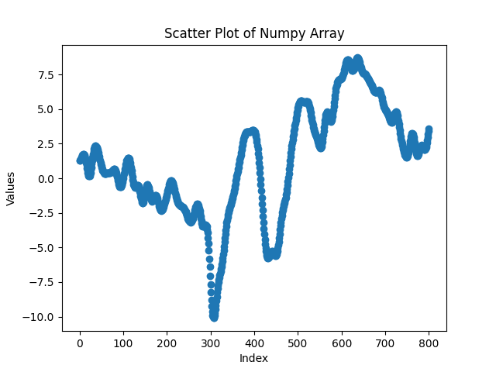
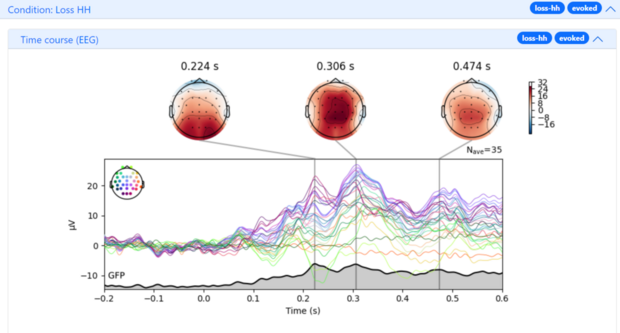

The mne_bids_pipeline plot shows all the channels. Since we are interested in FCz, the lavender color represents the lines around channel FCz.  In our scatter plot, the x-axis represents the indices starting from -200ms and representing 1ms each. Comparing the overall trend of the graph, it seems similar to the lavender graphs in the mne_bids_pipeline report, but unfortunately there is something wrong with the range of voltage values. Given our code, we did not catch any error in our retrieval of voltages from each epoch. Specifically, we retrieve the epochs from the mne.Epochs object and average all the epochs at their specific time steps for each condition in each subject. This leads us to conclude that the difference in voltages could lead to incorrect linear modeling, but for the sake of completeness, we proceeded with the erroneous data we retrieved.


### Visualizing the Data

Before we start building a linear model, let's take a look at what the data, i.e., the RewP values, look like. 

In [ ]:
data_with_prev_outcome = retrieve_data(selected_channel=SELECTED_CHANNEL, output_dir=OUTPUT_DIR, raw_ds_path=RAW_DS_PATH, filt_ds_path=FILT_DS_PATH_WITH_PREV_OUT, subjects_to_include=SUBJECTS_TO_INCLUDE, use_beh=USE_BEH_WITH_PREV_OUT)
cleaned_data = retrieve_data(selected_channel=SELECTED_CHANNEL, output_dir=OUTPUT_DIR, raw_ds_path=RAW_DS_PATH, filt_ds_path=CLEANED_FILT_DS_PATH_WO_PREV_OUT, subjects_to_include=SUBJECTS_TO_INCLUDE, use_beh=USE_BEH_WO_PREV_OUT)
data_with_prev_outcome = calculate_RewP_isolated_by_feature(data_with_prev_outcome, "prev_outcome")
cleaned_data = calculate_RewP_isolated_by_feature(cleaned_data)

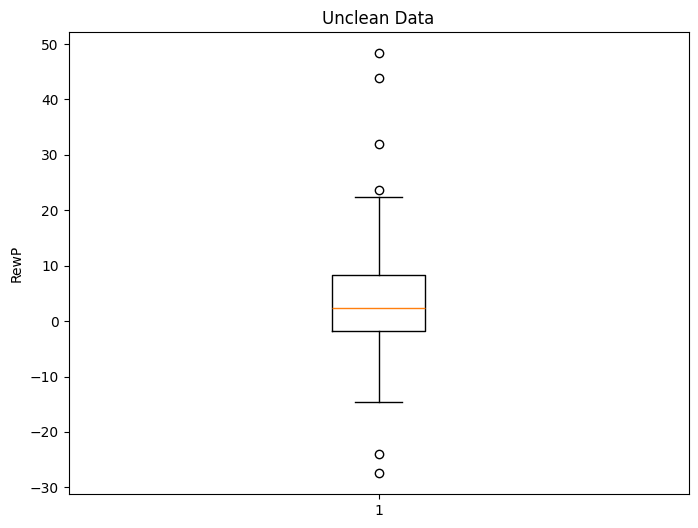

Sum of Squared Errors (SSE): 12788.779925155504


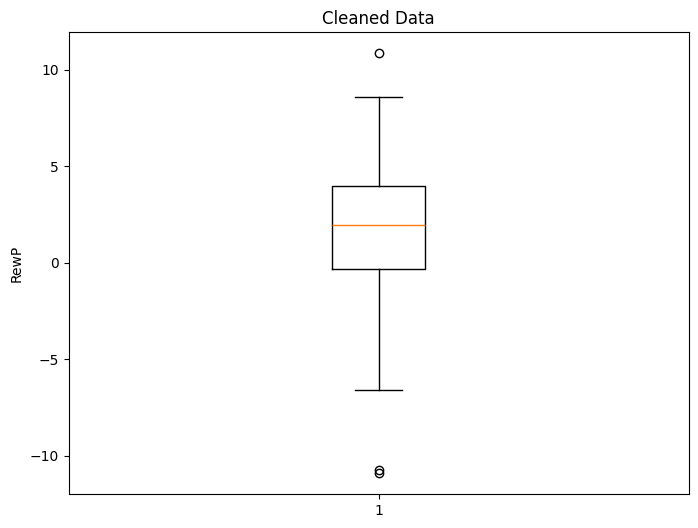

Sum of Squared Errors (SSE): 954.0344696153215


In [4]:
plot_boxplot_and_sse(data_with_prev_outcome, VOLTAGE_TO_ANALYZE, title="Unclean Data")
plot_boxplot_and_sse(cleaned_data, VOLTAGE_TO_ANALYZE, title="Cleaned Data")

### Data With Previous Outcome (Uncleaned)
The distribution of the RewP values does not match the distribution according to the paper (Figure 3d). In the paper, the RewP values are mostly positive, indicating that a win, on average, has a higher positive voltage than a loss across all tasks. Looking at our box plot, we have about 40% RewP values that are negative. This difference can be explained by taking another look at the correctly cleaned epochs.

### Cleaned Data
Looking at the lower box plot (cleaned data), we can see that most of the RewP values are positive. From this we can conclude that a careful selection of the bad ICA components has yielded good results, which are more in line with the results of the paper (RewP values should be positive in all task-cue pairs).


The calculated SSE is our baseline value for linear modeling. This is the value we get when **no** independent variables are considered, i.e., the linear model consists only of the intercept, which is represented as the mean. As a next step, we want to carefully select predictors for our linear model to reduce the SSE and thus better understand the baseline variance we currently have.

## Potential Predictors

Given the paper, 3 predictors can be derived to help understand the variance in the RewP values, namely task, cue, outcome, and performance. When selecting predictors for a multiple linear regression model, it is important that the predictors are **independent** of each other. Task, cue, and outcome are all categorical variables, and when categorical variables are truly independent, it means that the value of one categorical variable does not change the probability distribution of the other categorical variable at all.

First, lets consider the task cue variables. These are clearly dependent on each other by design, due to the simple fact that the task or casino is defined by the types of cues or slots they have, i.e. a low task will have only low cues, a medium task will have an equal amount of low and high cues, and so on. Thus, we can combine the task cue variables into a single categorical variable, resulting in these values: high-high, mid-high mid-low, low-low (the former word indicating the task value and the latter indicating the cue value). 

The predictor outcome can be completely discarded as the outcome was used to calculate the dependent variable RewP (mean win - mean loss).

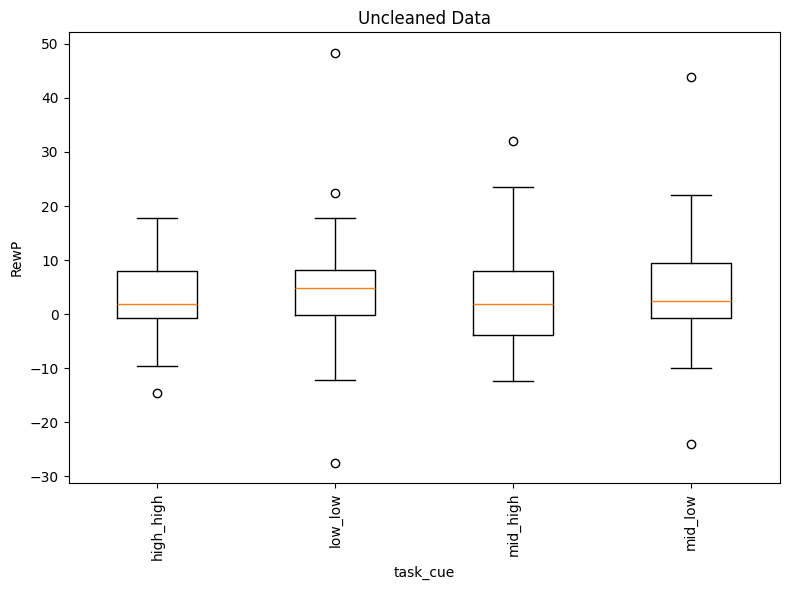

                sum_sq     df         F    PR(>F)
task_cue     80.598840    3.0  0.219866  0.882415
Residual  12708.181086  104.0       NaN       NaN

Eta-squared (η²): 0.006302308749244049


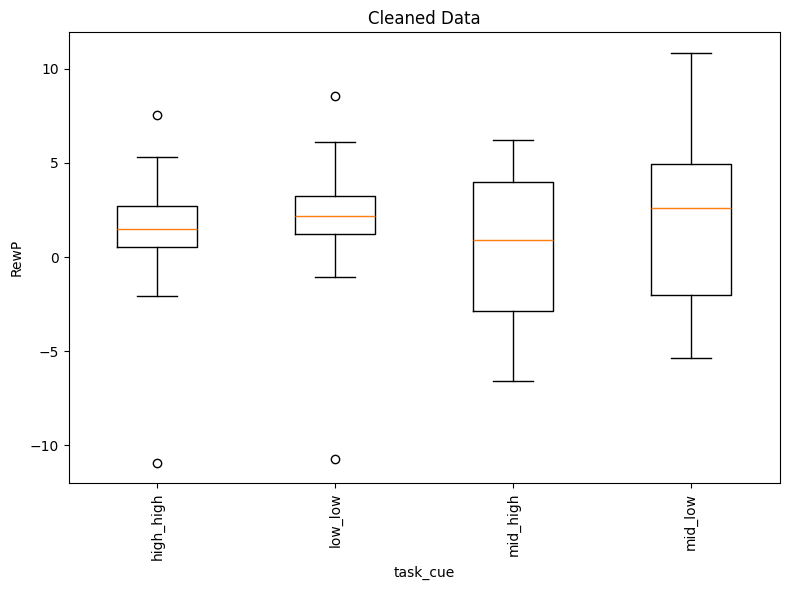

              sum_sq    df         F    PR(>F)
task_cue   24.808134   3.0  0.391565  0.759653
Residual  929.226336  44.0       NaN       NaN

Eta-squared (η²): 0.02600339383178071


In [5]:
# pair up task and cue
data_with_prev_outcome['task_cue'] = data_with_prev_outcome['task'] + '_' + data_with_prev_outcome['cue']
analyze_categorical_feature("task_cue", data_with_prev_outcome, title="Uncleaned Data")

cleaned_data['task_cue'] = cleaned_data['task'] + '_' + cleaned_data['cue']
analyze_categorical_feature("task_cue", cleaned_data, title="Cleaned Data")

Given the box plots, there does not appear to be a significant difference in the task-cue pair for both the uncleaned and cleaned epochs. The anova tables for both data confirm that the task-cue pair is not significant in explaining the variance in RewP. This result contradicts with the results from the paper, especially regarding the high-high pair vs the mid-high pair, there should be a significant differences in the RewP generated as this was the central research question of the authors that the RewP value generated **IS** in context of the current task. 

According to the paper, the pair high_high pair should be the lowest out of all task-cue pairs. Even in our cleaned data this is not the case. Another interesting point is that the mid-high pair has negative RewP values for the cleaned data. We have taken a closer look at our implementation and are sure that nothing went wrong here.

We conclude that the discrepancies in the results are either due to our different approach to preprocessing, to the missing participants from the other test site or the failing sanity check.



## Predictor Performance

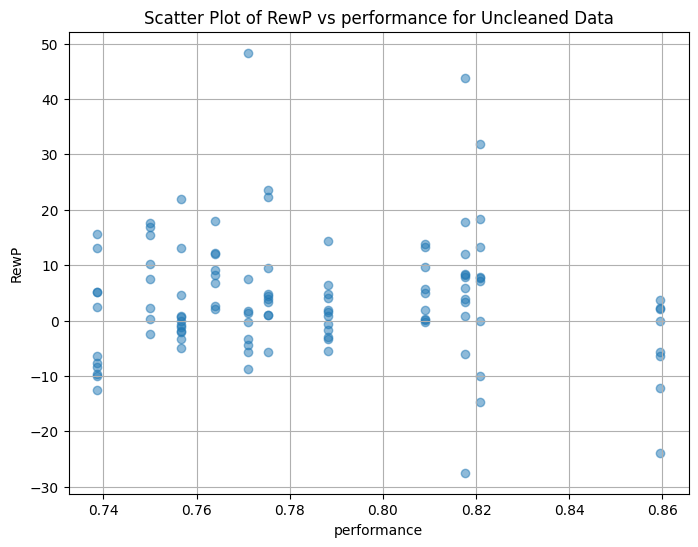

Correlation between performance and RewP: -0.05925072322555279
P-value: 0.5424435178243895
R-squared: 0.0035106482027510606


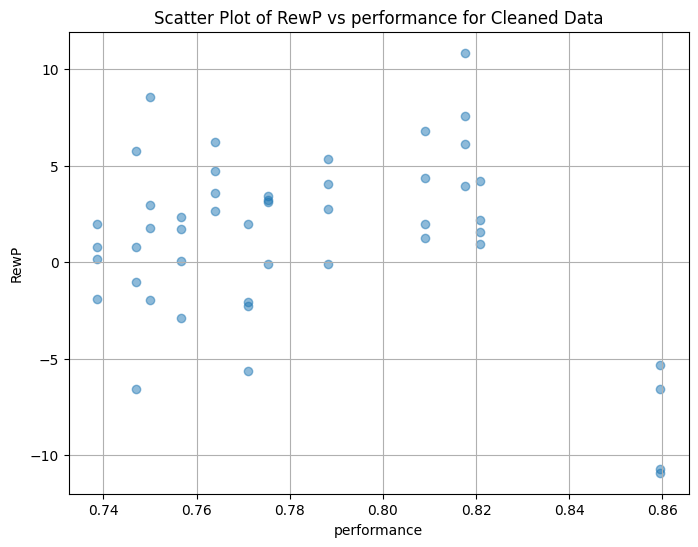

Correlation between performance and RewP: -0.20492436404067055
P-value: 0.1623499139943837
R-squared: 0.04199399497747327


In [6]:
analyze_numerical_feature(feature="performance", data=data_with_prev_outcome, title="Uncleaned Data")
analyze_numerical_feature(feature="performance", data=cleaned_data, title="Cleaned Data")

Given the performance of each participant, the scatter plot in the cleaned data looks similar to Figure 4 from the paper. The differences here are that the task-cue pairs were not aggregated. Also, the negative correlation in our data contradicts the positive correlation in the paper. It is interesting to note in our scatterplot that the best performer (sub-28) is an outlier from the rest. Sub-28 corresponds very closely to the lower right point in Figure 4. These results highlight the lack of sample size in our case, as the single outlier makes the correlation coefficient negative.

### Self-chosen Predictors

We decided to look for two other potential predictors, namely response time, i.e. how fast a participant pulls the arm out of the slot, and previous outcome. We hypothesize that both of these predictors may be good candidates for understanding the variance in RewP.

###  1. Self-Chosen Predictor: Response Time

We hypothesize that a participant will click the button faster if they are confident in their choice. Conversely, if the participant has not yet learned a pattern for a cue, or if there is no pattern to learn, i.e., for low cues, the participant might be thinking about which choice to make, leading to a longer response time. If participants are confident, i.e. respond quickly, this could influence the RewP generated.


#### Sanity Check for Response Time

In our sanity check we will **only consider the medium task**. In the medium task, where both types of cues are present, we hypothesize that, particularly in this type of casino, it should be rewarding for a participant to be presented with a cue for which the participant has already learned the pattern (represented by the presumed faster click) due to the presence of low cues, and therefore frustrating to learn a presumed pattern for a non-learnable cue. 
We use 3 metrics to check whether the data indicate faster response times on learned trials or not, namely Z-score, percentile of response time error, and absolute response time error.

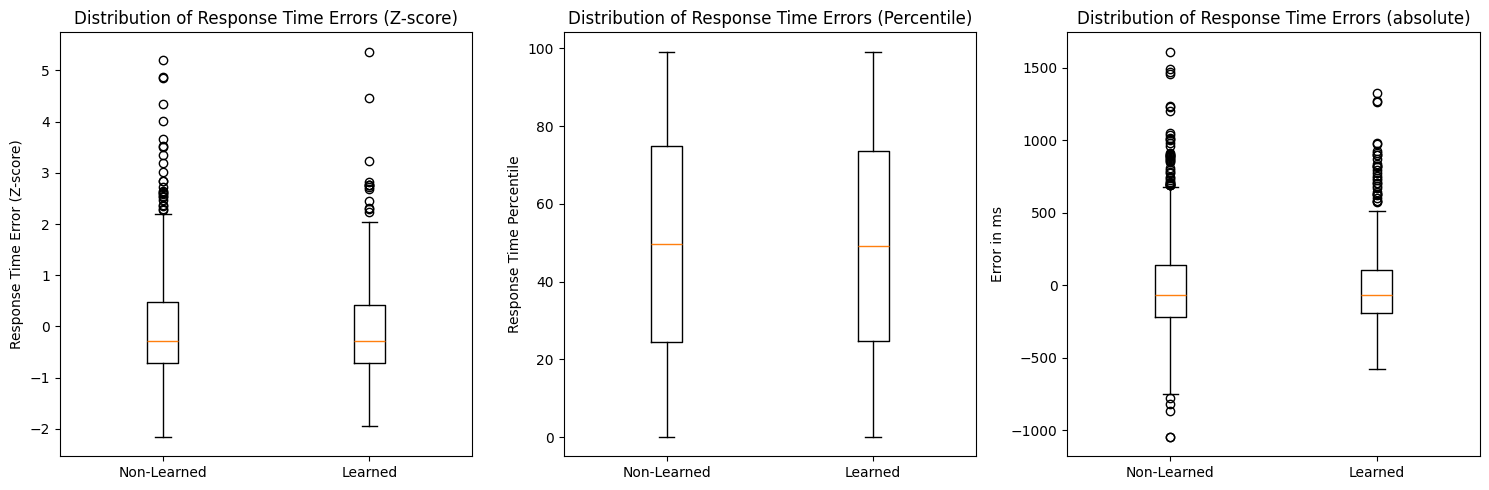

In [7]:
subjects_dir = 'Dataset/ds004147-filtered'
subject_dirs = [d for d in os.listdir(subjects_dir) if os.path.isdir(os.path.join(subjects_dir, d)) and "sub" in d]

dfs = []
for subject_dir in subject_dirs:
    df = create_df_from_beh_tsv(os.path.join(subjects_dir, subject_dir, "beh", f"{subject_dir}_task-casinos_beh.tsv"))
    dfs.append(df)
    
df = pd.concat(dfs, ignore_index=True)

# Filter by medium task (task=2)
df2 = df[df['task'] == 2]

# Filter by cue type: Non-Learned (prob=50) and Learned (prob=80, optimal=outcome)
df2_non_learned = df2[(df2['prob'] == 50) | ((df2['prob'] == 80) & (df2['outcome'] == 0))]
df2_learned = df2[(df2['prob'] == 80) & (df2['optimal'] == 1) & (df2['outcome'] == 1)]

# Combine data for box plot
combined_data = pd.concat([df2_non_learned["rt_z_score"], df2_learned["rt_z_score"]], axis=1)
combined_data.columns = ['Non-Learned', 'Learned']

# Box plot for Z-score
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.boxplot([df2_non_learned["rt_z_score"], df2_learned["rt_z_score"]])
plt.xticks([1, 2], ['Non-Learned', 'Learned'])
plt.ylabel('Response Time Error (Z-score)')
plt.title('Distribution of Response Time Errors (Z-score)')

# Box plot for Percentile
plt.subplot(1, 3, 2)
plt.boxplot([df2_non_learned["rt_percentile"], df2_learned["rt_percentile"]])
plt.xticks([1, 2], ['Non-Learned', 'Learned'])
plt.ylabel('Response Time Percentile')
plt.title('Distribution of Response Time Errors (Percentile)')

# Box plot for Residuals
plt.subplot(1, 3, 3)
plt.boxplot([df2_non_learned["residuals"], df2_learned["residuals"]])
plt.xticks([1, 2], ['Non-Learned', 'Learned'])
plt.ylabel('Error in ms')
plt.title('Distribution of Response Time Errors (absolute)')

plt.tight_layout()
plt.show()

#### Result: No significant differences in response time for learned and non-learned trials


Based on the three box plots showing response time errors for each subject in the medium task, there do not appear to be significant differences between non-learned and learned trials. This suggests that our hypothesis that subjects will pull the lever faster when they are more confident is most likely incorrect.

Several factors could contribute to this result. First, regardless of whether the subject already "knows" which arm to pull, there is an inherent processing time required to determine which action to take. This processing time is influenced by the number of different cues the subject has to remember.

Second, our assumption that confidence leads to faster responses may also be inaccurate. It's worth noting that subjects do not receive any tangible benefit from faster responses. Therefore, motivation to respond quickly may not be as important as we originally hypothesized.

**Thus, we conclude that using response time as a predictor is most likely not a good choice for linear modeling, as no difference between learned and unlearned trials can be extracted.**.

### 2. Self-Chosen Predictor: Previous Outcome

For this predictor, we hypothesize that the previous outcome could influence the RewP generated on the next trial. To verify whether the previous outcome is an appropriate predictor, we test the relationship of the previous outcome with the task-cue pair using a chi-squared test. 

Note: As mentioned above, due to index mismatch with the cleaned data, we can only use the prior score as a predictor for the uncleaned data.
Note²: In a real case scenario, we would no longer compute the chi-squared test for the previous outcome and the task_cue, since the task-cue pair is not significant for the out data. Since this result contradicts the authors, we will still include the task-cue pair in our linear model.

In [8]:
perform_chi_squared_test(data_with_prev_outcome, "prev_outcome", "task_cue")

Chi-squared test results:
Chi-square statistic: 1.3108965517241384
P-value: 0.9710534560916608
Degrees of freedom: 6
Contingency Table (Observed frequencies):
task_cue      high_high  low_low  mid_high  mid_low
prev_outcome                                       
invalid               5        7         5        3
loss                 11       11        11       11
win                  11       11        11       11
Expected frequencies:
[[ 5.          5.37037037  5.          4.62962963]
 [11.         11.81481481 11.         10.18518519]
 [11.         11.81481481 11.         10.18518519]]


Given the results of the chi-squared tests, there is no significant association between the variables task-cue and previous outcome. Thus both task-cue and previous outcome can be included into the linear model.

Next, we check if the previous outcome has a good relationship with the RewP values

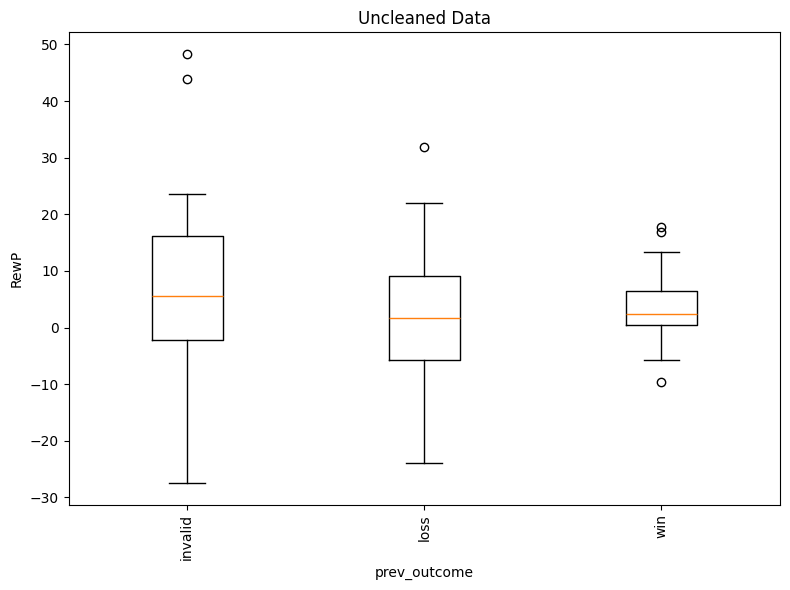

                    sum_sq     df         F   PR(>F)
prev_outcome    566.313330    2.0  2.432525  0.09275
Residual      12222.466595  105.0       NaN      NaN

Eta-squared (η²): 0.044282045175673766


In [9]:
analyze_categorical_feature(data=data_with_prev_outcome, feature="prev_outcome", title="Uncleaned Data")

While the p-value from the anova table is slightly higher than the conventional p-values (p=0.05 and p=0.01), the eta-squared of 4.2% suggests a small to medium contribution to variance for RewP. Therefore, we still include the previous result as a predictor.

### Multiple Linear Regression

Numerical independent variables can be represented by just a single variable whereas for a categorical independent variable we have to create n - 1 dummy variables where n is the number of categories. This results in the following variables:
- Task_Cue Pair: categorical; x1, x2, x3 to represent LowLow / MidLow / MidHigh / HighHigh
- Performance: numeric; x4
- Previous Outcome: categorical; x5 

#### E(RewP) = β₀ + β₁x₁ + β₂x₂ + β₃x₃ + β₄x₄ + β₅x₅


In [10]:
data_with_prev_outcome_dummy = pd.get_dummies(data_with_prev_outcome, columns=["task_cue", "prev_outcome"], drop_first=True) 
# model_formula = 'RewP ~ performance + task_cue_low_low + task_cue_mid_high + task_cue_mid_low + outcome_win + prev_outcome_win'
model_formula = f'{VOLTAGE_TO_ANALYZE} ~ task_cue_low_low + task_cue_mid_high + task_cue_mid_low + prev_outcome_loss + prev_outcome_win + performance'
model = ols(formula=model_formula, data=data_with_prev_outcome_dummy).fit()
print(model.summary())

residuals = model.resid
SSE = np.sum(residuals ** 2)
print("Sum of Squared Errors (SSE):", SSE)




                            OLS Regression Results                            
Dep. Variable:                   RewP   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9447
Date:                Sun, 31 Mar 2024   Prob (F-statistic):              0.467
Time:                        19:29:28   Log-Likelihood:                -408.10
No. Observations:                 108   AIC:                             830.2
Df Residuals:                     101   BIC:                             849.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### Results for uncleaned data (with previous outcome)

The model shows that it does not explain any variance in RewP values at all given the adj. R-squared of 0.001. The predictors do not seem to be statistically significant except for the previous result loss. For most of these predictors, this is consistent with the chi-squared test performed earlier. This is because we are working with uncleaned data and a limited sample size where outliers such as subject 28 strongly influence the data.


In [11]:
cleaned_data_dummy = pd.get_dummies(cleaned_data, columns=["task_cue"], drop_first=True) 
# model_formula = 'RewP ~ performance + task_cue_low_low + task_cue_mid_high + task_cue_mid_low + outcome_win + prev_outcome_win'
model_formula = f'{VOLTAGE_TO_ANALYZE} ~ task_cue_low_low + task_cue_mid_high + task_cue_mid_low + performance'
model = ols(formula=model_formula, data=cleaned_data_dummy).fit()
print(model.summary())

residuals = model.resid
SSE = np.sum(residuals ** 2)
print("Sum of Squared Errors (SSE):", SSE)

                            OLS Regression Results                            
Dep. Variable:                   RewP   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.7843
Date:                Sun, 31 Mar 2024   Prob (F-statistic):              0.542
Time:                        19:29:28   Log-Likelihood:                -138.17
No. Observations:                  48   AIC:                             286.3
Df Residuals:                      43   BIC:                             295.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Results on the cleaned data

For the regression model, an adjusted R-squared value of -0.019 indicates an even worse fit to the data. None of the predictors are statistically significant, meaning that there is insufficient evidence that any of the predictors have a meaningful effect on the outcome variable RewP.